In [1]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Lambda, Concatenate
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import os
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.io as isoio
import isolearn.keras as iso

from scipy.stats import pearsonr


Using TensorFlow backend.


<h2>Load 5' Alternative Splicing Data</h2>

- Load a Pandas DataFrame + Matlab Matrix of measured Splicing Sequences<br/>
- isolearn.io loads all .csv and .mat files of a directory into memory as a dictionary<br/>
- The DataFrame has one column - padded_sequence - containing the splice donor sequence<br/>
- The Matrix contains RNA-Seq counts of measured splicing at each position across the sequence<br/>


In [34]:
#Load Splicing Data

splicing_dict = isoio.load('data/processed_data/splicing_5ss_data/splicing_5ss_data')


<h2>Create a Training and Test Set</h2>

- We create an index containing row numbers corresponding to training and test sequences<br/>
- Notice that we do not alter the underlying DataFrame, we only make lists of pointers to rows<br/>


In [35]:
#Generate training, validation and test set indexes

valid_set_size = 0.10
test_set_size = 0.10

data_index = np.arange(len(splicing_dict['df']), dtype=np.int)

train_index = data_index[:-int(len(data_index) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(data_index) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))

Training set size = 211718
Validation set size = 26465
Test set size = 26464


<h2>Create Data Generators</h2>

- In Isolearn, we always build data generators that will encode and feed us the data on the fly<br/>
- Here, for example, we create a training and test generator separately (using list comprehension)<br/>
- First argument: The list of row indices (of data points) for this generator<br/>
- Second argument: Dictionary or data sources<br/>
- Third argument: Batch size for the data generator
- Fourth argument: List of inputs, where each input is specified as a dictionary of attributes<br/>
- Fifth argument: List of outputs<br/>
- ... (see next example for description of argument 6)<br/>
- Seventh argument: Shuffle the dataset or not<br/>
- Eight argument: True if some data source matrices are in sparse format<br/>
- Ninth argument: In Keras, we typically want to specfiy the Outputs as Inputs when training. <br/>This argument achieves this by moving the outputs over to the input list and replaces the output with a dummy encoder.<br/>

In this example, we specify two One-Hot encoders as the input encoders for different parts of the splice donor sequence.<br/>
We also specify the target output as the normalized RNA-Seq count at position 120 in the count matrix for each cell line (4 outputs).

In [36]:
#Create a One-Hot data generator, to be used for a convolutional net to regress SD1 Usage

splicing_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : splicing_dict['df'],
            'hek_count' : splicing_dict['hek_count'],
            'hela_count' : splicing_dict['hela_count'],
            'mcf7_count' : splicing_dict['mcf7_count'],
            'cho_count' : splicing_dict['cho_count'],
        },
        batch_size=32,
        inputs = [
            {
                'id' : 'random_region_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['padded_sequence'][122: 122 + 35],
                'encoder' : iso.OneHotEncoder(seq_length=35),
                'dim' : (35, 4),
                'sparsify' : False
            },
            {
                'id' : 'random_region_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['padded_sequence'][165: 165+35],
                'encoder' : iso.OneHotEncoder(seq_length=35),
                'dim' : (35, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : cell_type + '_sd1_usage',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : lambda c, index: np.ravel(c),
                'transformer' : lambda t: t[120] / np.sum(t)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ],
        randomizers = [],
        shuffle = True if gen_id in ['train'] else False,
        densify_batch_matrices=True,
        move_outputs_to_inputs=True if gen_id in ['train', 'valid'] else False
    ) for gen_id, idx in [('train', train_index), ('valid', valid_index), ('test', test_index)]
}


<h2>Keras Loss Functions</h2>

Here we specfiy a few loss function (Cross-Entropy and KL-divergence) to be used when optimizing our Splicing CNN.<br/>


In [38]:
#Keras loss functions

def sigmoid_entropy(inputs) :
    y_true, y_pred = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    
    return -K.sum(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred), axis=-1)

def mean_sigmoid_entropy(inputs) :
    y_true, y_pred = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    
    return -K.mean(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred), axis=-1)

def sigmoid_kl_divergence(inputs) :
    y_true, y_pred = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    
    return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)

def mean_sigmoid_kl_divergence(inputs) :
    y_true, y_pred = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    
    return K.mean(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)


<h2>Splicing Model Definition</h2>

Here we specfiy the Keras Inputs that we expect to receive from the data generators.<br/>
We also define the model architecture (2 convolutional-layer CNN with MaxPooling and layer sharing).<br/>

In [39]:
#Splicing Model Definition (CNN)

#Inputs

seq_input_1 = Input(shape=(35, 4))
seq_input_2 = Input(shape=(35, 4))

#Outputs

true_usage_hek = Input(shape=(1,))
true_usage_hela = Input(shape=(1,))
true_usage_mcf7 = Input(shape=(1,))
true_usage_cho = Input(shape=(1,))

#Shared Model Definition (Applied to each randomized sequence region)

layer_1 = Conv1D(64, 8, padding='valid', activation='relu')
layer_1_pool = MaxPooling1D(pool_size=2)
layer_2 = Conv1D(128, 6, padding='valid', activation='relu')

def shared_model(seq_input) :
    return Flatten()(
        layer_2(
            layer_1_pool(
                layer_1(
                    seq_input
                )
            )
        )
    )


shared_out_1 = shared_model(seq_input_1)
shared_out_2 = shared_model(seq_input_2)

#Layers applied to the concatenated hidden representation

layer_dense = Dense(256, activation='relu')
layer_drop = Dropout(0.2)

concat_out = Concatenate(axis=-1)([shared_out_1, shared_out_2])

dropped_dense_out = layer_drop(layer_dense(concat_out))

#Final cell-line specific regression layers

layer_usage_hek = Dense(1, activation='sigmoid', kernel_initializer='zeros')
layer_usage_hela = Dense(1, activation='sigmoid', kernel_initializer='zeros')
layer_usage_mcf7 = Dense(1, activation='sigmoid', kernel_initializer='zeros')
layer_usage_cho = Dense(1, activation='sigmoid', kernel_initializer='zeros')

pred_usage_hek = layer_usage_hek(dropped_dense_out)
pred_usage_hela = layer_usage_hela(dropped_dense_out)
pred_usage_mcf7 = layer_usage_mcf7(dropped_dense_out)
pred_usage_cho = layer_usage_cho(dropped_dense_out)

#Compile Splicing Model

splicing_model = Model(
    inputs=[
        seq_input_1,
        seq_input_2
    ],
    outputs=[
        pred_usage_hek,
        pred_usage_hela,
        pred_usage_mcf7,
        pred_usage_cho
    ]
)


<h2>Loss Model Definition</h2>

Here we specfiy our loss function, and we build it as a separate Keras Model.<br/>
In our case, our loss model averages the KL-divergence of predicted vs. true Splice Donor Usage across the 4 different cell types.<br/>

In [40]:
#Loss Model Definition

loss_hek = Lambda(sigmoid_kl_divergence, output_shape = (1,))([true_usage_hek, pred_usage_hek])
loss_hela = Lambda(sigmoid_kl_divergence, output_shape = (1,))([true_usage_hela, pred_usage_hela])
loss_mcf7 = Lambda(sigmoid_kl_divergence, output_shape = (1,))([true_usage_mcf7, pred_usage_mcf7])
loss_cho = Lambda(sigmoid_kl_divergence, output_shape = (1,))([true_usage_cho, pred_usage_cho])


total_loss = Lambda(
    lambda l: (l[0] + l[1] + l[2] + l[3]) / 4.,
    output_shape = (1,)
)(
    [
        loss_hek,
        loss_hela,
        loss_mcf7,
        loss_cho
    ]
)

#Must be the same order as defined in the data generators
loss_model = Model([
    #Inputs
    seq_input_1,
    seq_input_2,
    
    #Target SD Usages
    true_usage_hek,
    true_usage_hela,
    true_usage_mcf7,
    true_usage_cho
], total_loss)

<h2>Optimize the Loss Model</h2>

Here we use SGD to optimize the Loss Model (defined in the previous notebook cell).<br/>
Since our Loss Model indirectly depends on predicted outputs from our CNN Splicing Model, SGD will optimize the weights of our CNN<br/>
<br/>

Note that we very easily pass the data generators, and run them in parallel, by simply calling Keras fit_generator.<br/>


In [41]:
#Optimize CNN with Keras using the Data Generators to stream genomic data features

opt = keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

callbacks =[
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=0, mode='auto')
]

loss_model.fit_generator(
    generator=splicing_gens['train'],
    validation_data=splicing_gens['valid'],
    epochs=10,
    use_multiprocessing=True,
    workers=4,
    callbacks=callbacks
)


Epoch 1/10
6616/6616 [==============================] - 241s 36ms/step - loss: 0.1141 - val_loss: 0.1084
Epoch 2/10
6616/6616 [==============================] - 236s 36ms/step - loss: 0.0899 - val_loss: 0.0863
Epoch 3/10
6616/6616 [==============================] - 241s 36ms/step - loss: 0.0847 - val_loss: 0.0844
Epoch 4/10
6616/6616 [==============================] - 248s 38ms/step - loss: 0.0815 - val_loss: 0.0916
Epoch 5/10
6616/6616 [==============================] - 245s 37ms/step - loss: 0.0785 - val_loss: 0.0826
Epoch 6/10
6616/6616 [==============================] - 249s 38ms/step - loss: 0.0759 - val_loss: 0.0881
Epoch 7/10
6616/6616 [==============================] - 252s 38ms/step - loss: 0.0736 - val_loss: 0.0853


In [42]:
#Save model
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'splicing_cnn_multicell.h5'
model_path = os.path.join(save_dir, model_name)
splicing_model.save(model_path)

print('Saved trained model at %s ' % model_path)

Saved trained model at /home/johli/isolearn/example/saved_models/splicing_cnn_multicell.h5 


In [43]:
#Load model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'splicing_cnn_multicell.h5'
model_path = os.path.join(save_dir, model_name)

splicing_model = load_model(model_path)

<h2>Evaluate the Splicing CNN</h2>

Here we run our Splicing CNN on the Test set data generator (using Keras predict_generator).<br/>
We then compare our predictions of splice donor usage against the true RNA-Seq measurements.<br/>


Test set R^2 = 0.87, p = 0.0


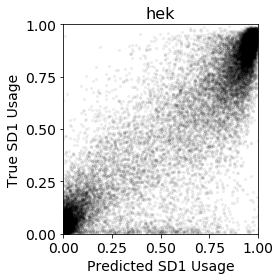

Test set R^2 = 0.87, p = 0.0


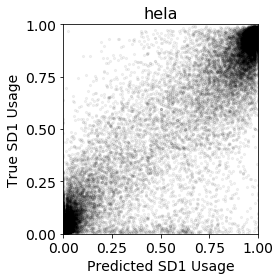

Test set R^2 = 0.86, p = 0.0


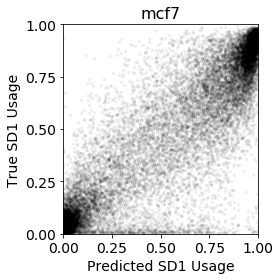

Test set R^2 = 0.87, p = 0.0


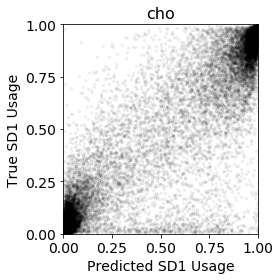

In [44]:
#Evaluate predictions on test set

predictions = splicing_model.predict_generator(splicing_gens['test'], workers=4, use_multiprocessing=True)
pred_usage_hek, pred_usage_hela, pred_usage_mcf7, pred_usage_cho = [np.ravel(prediction) for prediction in predictions]

targets = zip(*[splicing_gens['test'][i][1] for i in range(len(splicing_gens['test']))])
true_usage_hek, true_usage_hela, true_usage_mcf7, true_usage_cho = [np.concatenate(list(target)) for target in targets]

cell_lines = [
    ('hek', (pred_usage_hek, true_usage_hek)),
    ('hela', (pred_usage_hela, true_usage_hela)),
    ('mcf7', (pred_usage_mcf7, true_usage_mcf7)),
    ('cho', (pred_usage_cho, true_usage_cho))
]

for cell_name, [y_true, y_pred] in cell_lines :
    
    r_val, p_val = pearsonr(y_pred, y_true)
    print("Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

    #Plot test set scatter
    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred, y_true, color='black', s=5, alpha=0.05)
    
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.xlabel('Predicted SD1 Usage', fontsize=14)
    plt.ylabel('True SD1 Usage', fontsize=14)
    plt.title(str(cell_name), fontsize=16)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
